In [ ]:
!pip install jcopml

     |████████████████████████████████| 100 kB 4.3 MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.14-py2.py3-none-any.whl size=33654 sha256=099cf9e6abbf13db531640a1c40bb7834295defa6d96b50452cdd8037b92de40
  Stored in directory: /root/.cache/pip/wheels/d9/6a/86/9a622c06f65732afe0e31c02a92fae6ab663ffd7162bcf5125
Successfully built jcopml


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [ ]:
df = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Mini EDA

,missing_value,%
age,0,0.0
anaemia,0,0.0
creatinine_phosphokinase,0,0.0
diabetes,0,0.0
ejection_fraction,0,0.0
high_blood_pressure,0,0.0
platelets,0,0.0
serum_creatinine,0,0.0
serum_sodium,0,0.0
sex,0,0.0


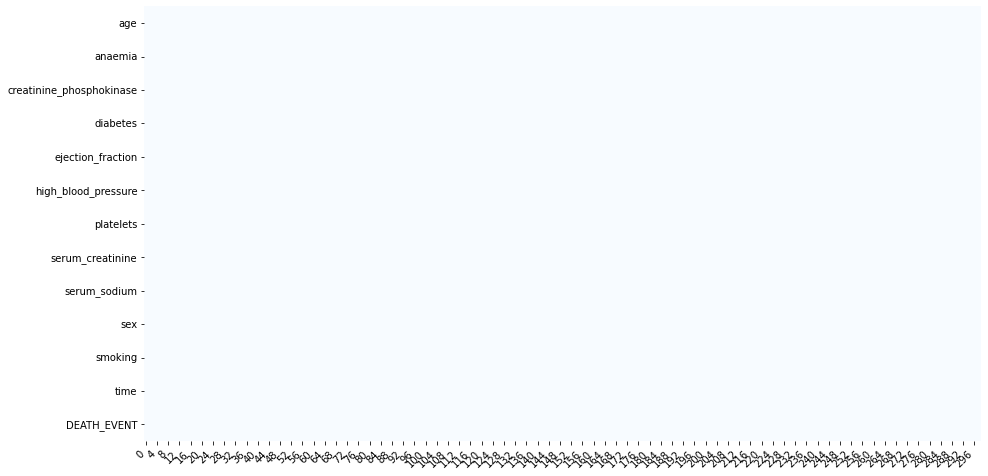

In [ ]:
# Check Missing Value
plot_missing_value(df, return_df=True)

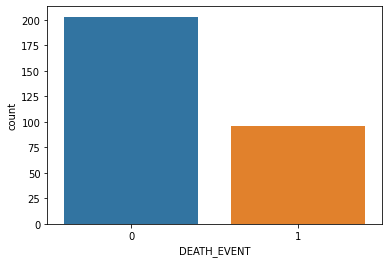

In [ ]:
# Check Imbalanced Data
import seaborn as sns
sns.countplot(data=df, x='DEATH_EVENT');

In [ ]:
# Check Imbalanced Data
df.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

# Dataset Splitting

In [ ]:
X = df.drop(columns=['DEATH_EVENT'])
y = df.DEATH_EVENT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((239, 12), (60, 12), (239,), (60,))

# Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from jcopml.tuning import random_search_params as rsp, grid_search_params as gsp, bayes_search_params as bsp # Berisi parameter untuk Tuning model

In [ ]:
numeric_feat = X_train.drop(columns=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']).columns.values
categoric_feat = X_train[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']].columns.values

## Random Forest

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), numeric_feat),
    ('categoric', cat_pipe(), categoric_feat)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# Training
model_rf = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1, scoring='f1')
model_rf.fit(X_train, y_train)

# Evaluation
print(model_rf.best_params_)
print(model_rf.score(X_train, y_train), model_rf.best_score_, model_rf.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 10, 'algo__n_estimators': 100}
0.8299319727891157 0.758612956577804 0.7096774193548387


## XGBoost

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), numeric_feat),
    ('categoric', cat_pipe(), categoric_feat)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

# Training
model_xgb = GridSearchCV(pipeline, gsp.xgb_params, cv=3, n_jobs=-1, verbose=1, scoring='f1')
model_xgb.fit(X_train, y_train)

# Evaluation
print(model_xgb.best_params_)
print(model_xgb.score(X_train, y_train), model_xgb.best_score_, model_xgb.score(X_test, y_test))

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
{'algo__colsample_bytree': 0.6, 'algo__gamma': 5, 'algo__learning_rate': 0.1, 'algo__max_depth': 3, 'algo__n_estimators': 200, 'algo__reg_alpha': 0.01, 'algo__reg_lambda': 0.01, 'algo__subsample': 0.4}
0.8666666666666666 0.7859206724454952 0.6875


# SVM

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), numeric_feat),
    ('categoric', cat_pipe(), categoric_feat)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', SVC(random_state=42))
])

# Training
model_svm = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1, scoring='f1')
model_svm.fit(X_train, y_train)

# Evaluation
print(model_svm.best_params_)
print(model_svm.score(X_train, y_train), model_svm.best_score_, model_svm.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 100.0, 'algo__gamma': 0.01}
0.847682119205298 0.7200048379293662 0.5625


# Training with Feature Importance

array(['time', 'ejection_fraction', 'serum_creatinine',
       'creatinine_phosphokinase', 'age', 'serum_sodium'], dtype=object)

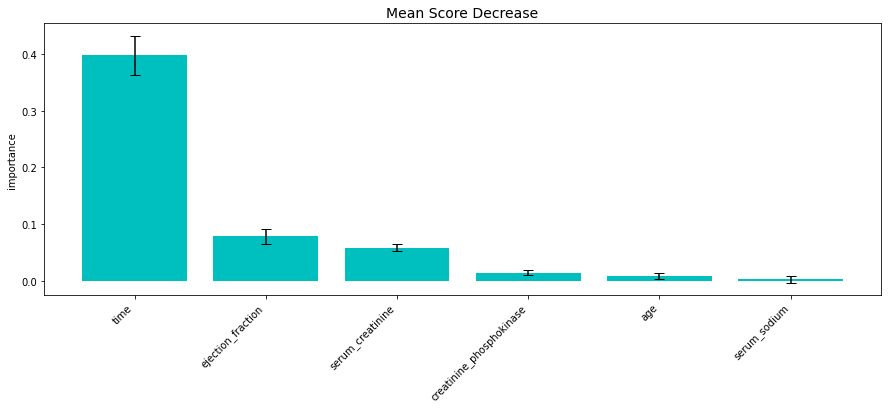

In [ ]:
# Model Random Forest
important_rf = mean_score_decrease(X_train, y_train, model_rf, plot=True, topk=6)
important_rf.feature.values

array(['time', 'ejection_fraction', 'serum_creatinine',
       'creatinine_phosphokinase', 'age', 'serum_sodium'], dtype=object)

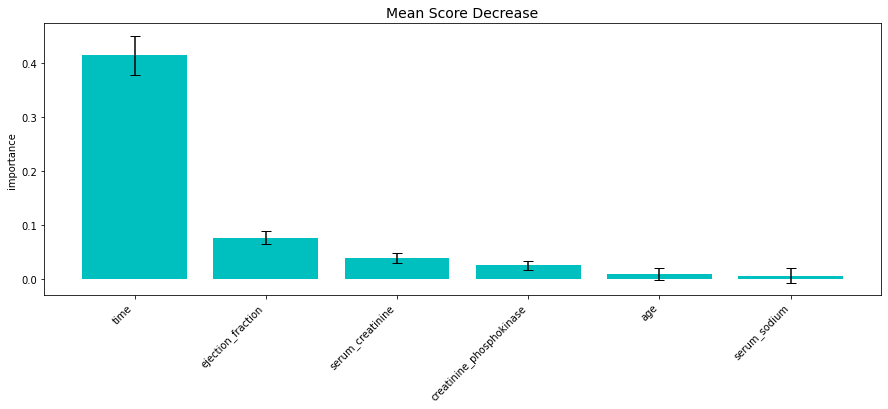

In [ ]:
# Model XGBoost
important_xgb = mean_score_decrease(X_train, y_train, model_xgb, plot=True, topk=6)
important_xgb.feature.values

array(['time', 'ejection_fraction', 'serum_creatinine', 'age',
       'creatinine_phosphokinase', 'serum_sodium'], dtype=object)

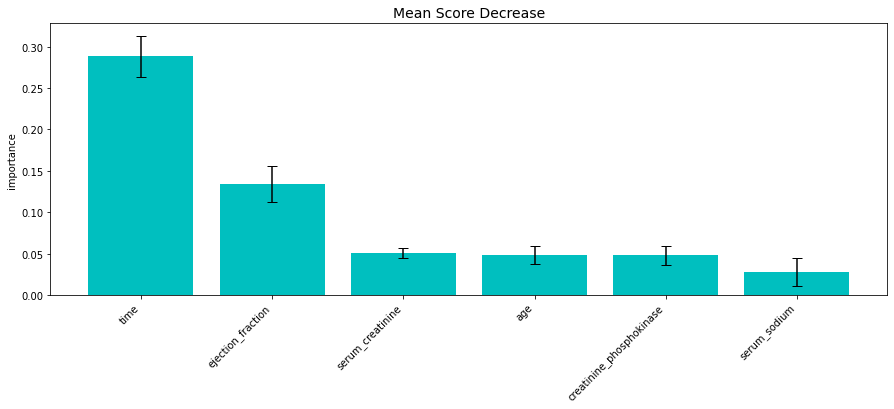

In [ ]:
# Model SVM
important_svm = mean_score_decrease(X_train, y_train, model_svm, plot=True, topk=6)
important_svm.feature.values

## Random Forest

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), important_rf.feature.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# Training
model_rf_imp = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1, scoring='f1')
model_rf_imp.fit(X_train, y_train)

# Evaluation
print(model_rf_imp.best_params_)
print(model_rf_imp.score(X_train, y_train), model_rf_imp.best_score_, model_rf_imp.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 100}
0.87248322147651 0.7527945350047776 0.7647058823529413


## XGBoost

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), important_xgb.feature.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

# Training
model_xgb_imp = GridSearchCV(pipeline, gsp.xgb_params, cv=3, n_jobs=-1, verbose=1, scoring='f1')
model_xgb_imp.fit(X_train, y_train)

# Evaluation
print(model_xgb_imp.best_params_)
print(model_xgb_imp.score(X_train, y_train), model_xgb_imp.best_score_, model_xgb_imp.score(X_test, y_test))

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
{'algo__colsample_bytree': 0.6, 'algo__gamma': 5, 'algo__learning_rate': 0.1, 'algo__max_depth': 6, 'algo__n_estimators': 100, 'algo__reg_alpha': 0.01, 'algo__reg_lambda': 0.01, 'algo__subsample': 0.4}
0.863013698630137 0.8040579710144927 0.6451612903225806


## SVM

In [ ]:
# Pipeline
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), important_svm.feature.values)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('sampling', SMOTE()),
    ('algo', SVC(random_state=42))
])

# Training
model_svm_imp = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1, scoring='f1')
model_svm_imp.fit(X_train, y_train)

# Evaluation
print(model_svm_imp.best_params_)
print(model_svm_imp.score(X_train, y_train), model_svm_imp.best_score_, model_svm_imp.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 1.0, 'algo__gamma': 0.1}
0.7891156462585034 0.7271459694989106 0.6285714285714286
